In [9]:
import gym
import numpy as np
env = gym.make('Ant-v4', new_step_api = True)
env.action_space.seed(42)

[42]

In [10]:
## Video of Ant Before Learning
from IPython.display import clear_output
import matplotlib.pyplot as plt
env.reset()

popup_render = True

for _ in range(700):
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    
    if popup_render:
        env.render(mode = 'human')
    else:
        clear_output(wait=True)
        plt.imshow( env.render(mode='rgb_array') )
        plt.show()
    
    if terminated:
        print('Term')
        break
    elif truncated:
        print('Outbound')
        break
    else:
        continue
        
        
#         observation, info = env.reset(return_info=True)

/home/linghao/env/p37_r/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


Term


In [12]:
env.close()

In [14]:
from torch import nn
import torch.nn.functional as F
import torch
import random 
import matplotlib.pyplot as plt
import numpy as np

## ----------------- Helpers ---------------- ## 

def flatten(nestedTuple: tuple):
    """
    flatten input dimensions for NNs
    """
    merged = []
    for item in nestedTuple:
        if isinstance(item, tuple) or isinstance(item, list):
            for i in item:
                merged.append(i)
        else:
            merged.append(item)  
    return merged   

## This function aims to help updating target actor/critic parameters
def targetUpdater(normalModel, targetModel, lRate = 0.3):
    for normalParam, targetParam in zip(normalModel.parameters(), targetModel.parameters()):
        targetParam.data.copy_(targetParam.data * (1.0 - lRate) + normalParam.data * lRate)
## This function aims to initilize target actor/critic parameters with normal Actor/Critc 
def initializer(normalModel, targetModel):
    for normalParam, targetParam in zip(normalModel.parameters(), targetModel.parameters()):
        targetParam.data.copy_(normalParam.data)
    
## ------------------ Actor ----------------- ## 

class Actor(nn.Module):
    """
    hidden layer can be further defined using another tuple e.g. (30, (128,64), 8) 
    or simply define in one tuple (30, 128, 64, 8)
    """
    def __init__(self, structure, use_dropout = False):
        
        super().__init__()
        
        layers = []
        ## Activation function:
        self.activation  = nn.ReLU()
        
        # Automatic population of FC network
        dim = flatten(structure)
        dim_shifted = dim[1:]
        
        for i in range(len(dim)-1):
            layers.append(nn.Linear(dim[i], dim_shifted[i]))
            
            ## Just in case for mitigating overfitting ...
            if use_dropout and i != len(dim)-2:
                layers.append(nn.Dropout(p = 0.2))
            
            if i != len(dim)-2:
                layers.append(self.activation)
        self.model = nn.Sequential(*layers)
        
    def forward(self, states):
        output = self.model(states)
        ## This is to scale back the actions to (-1, 1) for Ant environment !Need to change for other environmen
        output = torch.tanh(output)
        
        return output
    
## -------------------Critic ---------------- ## 
class Critic(nn.Module):
    """
    Critic network input dimension must equal the states_dim + actions_dim
    """
    def __init__(self, structure, use_dropout = False):
        super().__init__()
        
        layers = []
        ## Activation function:
        self.activation  = nn.ReLU()
        
        # Automatic population of FC network
        dim = flatten(structure)
        dim_shifted = dim[1:]
        
        for i in range(len(dim)-1):
            layers.append(nn.Linear(dim[i], dim_shifted[i]))
            
            ## Just in case for mitigating overfitting ...
            if use_dropout and i != len(dim)-2:
                layers.append(nn.Dropout(p = 0.2))
                
            if i != len(dim)-2:
                layers.append(self.activation)
        self.model = nn.Sequential(*layers)
        
    def forward(self, states, actions):
        
        ## concatenate states and actions, order shouldn't really matter
        inputs = torch.cat([states, actions], 1)
        output = self.model(inputs)
        return output


## -------------------Replay ---------------- ## 
class ReplayMemory():
    
    def __init__(self, size=500):
        self.size = size
        self.memory = []
        
    def addMemory(self, transition):
        """
        Transition composition:
        State, Action, Reward, `State
        """
        if self.isFull():
            ## If memory is full, remove the first stored elements
            self.memory.pop(0)
            
        self.memory.append(transition)
                
    def sample(self, batchSize):
        ## This is a very slow implementation - should be optimized if possible
        batch = random.sample(self.memory, batchSize)
        state, action, reward, stateNext, terminated = [], [], [], [], []
        for transition in batch:
            state.append(transition[0])
            action.append(transition[1])
            reward.append(transition[2])
            stateNext.append(transition[3])
            terminated.append(transition[4])
        
        return state, action, reward, stateNext, terminated
    
    def isFull(self):
        return len(self.memory)==self.size


## -------------------Random Policy ---------------- ## 
#! Ornstein-Ulhenbeck Process
#! Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
#! This is not my own implementation, might be an issue though
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ## this function returns not noise but action+noise
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)


In [2]:
import torch.optim as optim

class DDPGAgent:
    
    def __init__(self, actionSpace, actorStructure:tuple, criticStructure:tuple, use_dropout = False, actorLRate = 0.0003, criticLRate = 0.0003, criticLoss = 'HL', gamma = 0.9, targetUpdaterLRate = 0.3, replayMemorySize = 500, batchSize = 128, gpu = True):
        
        self.actor = Actor(structure=actorStructure, use_dropout = use_dropout)
        self.critic = Critic(structure=criticStructure, use_dropout = use_dropout)
        self.targetActor = Actor(structure=actorStructure, use_dropout = use_dropout)
        self.targetCritic = Critic(structure=criticStructure, use_dropout = use_dropout)

        self.batchSize = batchSize
        self.targetUpdaterLRate = targetUpdaterLRate
        self.gamma = gamma
        self.gpu = gpu
        
        if self.gpu:
            self.cuda()
        
        ## initialise target models 
        initializer(self.actor, self.targetActor)
        initializer(self.critic, self.targetCritic)
        
        ## initialise replay memory and random process
        self.rProcess = OUNoise(actionSpace)
        self.rMemory = ReplayMemory(replayMemorySize)
 
        
        ## initialise optimizer
        self.actorOptim = optim.Adam(self.actor.parameters(), lr=actorLRate)
        self.criticOptim = optim.Adam(self.critic.parameters(), lr=criticLRate)
        
        ## initialise Loss for critic, either Huber (default) or MSE (otherwise)
        if criticLoss == 'HL':
            self.criticCriteria = nn.HuberLoss()
        
        else:
            self.criticCriteria = nn.MSELoss()
        
    def updatePolicy(self):
        ## Assuming sufficient replay memory has been acquired
        
        ## 1. Sample (S, A, R, S`) in replay memory
        if self.rMemory.isFull():
            state, action, reward, stateNext, _ = self.rMemory.sample(self.batchSize)
        
            if self.gpu:
                state = torch.cuda.FloatTensor(state)
                action = torch.cuda.FloatTensor(action)
                reward = torch.cuda.FloatTensor(reward)
                stateNext = torch.cuda.FloatTensor(stateNext)
            else:
                state = torch.FloatTensor(state)
                action = torch.FloatTensor(action)
                reward = torch.FloatTensor(reward)
                stateNext = torch.FloatTensor(stateNext)

            ## 2. Gradient of actor and critic  

            y = self.gamma * self.targetCritic(stateNext.detach(), self.targetActor(stateNext).detach()) + reward
            y.requires_grad_()
            yBar = self.critic(state, action)
            criticLoss = self.criticCriteria(yBar, y)
            actorLoss = -self.critic(state, self.actor(state)).mean()


            ## backward losses
           
            self.actorOptim.zero_grad()
            actorLoss.backward()
            self.actorOptim.step()

            self.criticOptim.zero_grad()
            criticLoss.backward()
            self.criticOptim.step()

            ## 3. Update target actor / critic
            targetUpdater(self.critic, self.targetCritic, self.targetUpdaterLRate)
            targetUpdater(self.actor, self.targetActor, self.targetUpdaterLRate)
            
        else:
            raise ValueError("More replay memory needed")
    
    def getAction(self, states, step):
        if self.gpu:
            states = torch.cuda.FloatTensor(states)
        else:
            states = torch.FloatTensor(states)
        
        action = self.actor(states).detach().cpu().numpy()
        action = self.rProcess.get_action(action, step)
        return action
    
    def cuda(self):
        ## Move all models to GPU
        if torch.cuda.is_available():
            self.actor.cuda()
            self.critic.cuda()
            self.targetActor.cuda()
            self.targetCritic.cuda()
        else:
            raise ValueError("No Cuda Available")
            
    def cpu(self):
        ## Move all models back to CPU
        self.actor.cpu()
        self.critic.cpu()
        self.targetActor.cpu()
        self.targetCritic.cpu()
        
    def evalMode(self):
        ## Evaluation mode for Agent showcase 
        self.actor.eval()
        self.critic.eval()
        self.targetActor.eval()
        self.targetCritic.eval()  
        
    def trainMode(self):
        ## Training mode for updating parameters
        self.actor.train()
        self.critic.train()
        self.targetActor.train()
        self.targetCritic.train()   
        
    def saveModel(self, path):
        torch.save(self.actor.state_dict(),f'{path}/actor.pkl')
        torch.save(self.critic.state_dict(),f'{path}/critic.pkl')
    
    def loadModel(self, path):
        self.actor.load_state_dict(torch.load(f'{path}/actor.pkl'))
        self.critic.load_state_dict(torch.load(f'{path}/critic.pkl'))

In [19]:
def train(agent, env, epochs, replayMemorySize, printEvery = 100, savePath=None):
    ## Generate replay memory of size replayMemorySize:
    state = env.reset()
    agent.rProcess.reset()
    for t in range(replayMemorySize):
        action = agent.getAction(state, t)

        ## According to OPenAI doc for return type of env.step
        stateNext, reward, terminated, truncated, _ = env.step(action) 
        agent.rMemory.addMemory((state, action, np.array([reward]), stateNext, terminated))
        state = stateNext
        if terminated:
            agent.rProcess.reset()
            state = env.reset()

    # ## Training Loop
    try:
        for e in range(epochs):
            state = env.reset()
            agent.rProcess.reset()
            # time steps for generating random process
            t = 0    
            episodeR = 0
            # Training loop for each episode
            while True:
                action = agent.getAction(state, t)
                stateNext, reward, terminated, truncated, info = env.step(action)

                agent.rMemory.addMemory((state, action, np.array([reward]), stateNext, terminated))

                ## Update policy
                agent.updatePolicy()

                ## renew state and action
                state = stateNext
                episodeR += reward
                t+=1

                if terminated or truncated:
                    break    
            rewardTracking.append(episodeR)
            rewardAvg.append(np.mean(rewardTracking[-10:]))
            if (e+1)%printEvery == 0:
                print(f"Episode {e+1}: reward: {episodeR}, Avg: {rewardAvg[-1]}")

        if savePath!=None:
            agent.saveModel(savePath)
    
    ## In case looping for too long
    except KeyboardInterrupt:
        return rewardTracking, rewardAvg 
    
    return rewardTracking, rewardAvg 

In [25]:
"""
This script is used as main for learning
"""
import gym
import numpy as np

## reset environment, render is not used in training
env = gym.make('Ant-v4', new_step_api = True)
env.action_space.seed(42)
state = env.reset()

## Observation and action space size
observationNum = env.observation_space.shape[0]
actionNum = env.action_space.shape[0]
totalNum = observationNum + actionNum

## Training Parameters
epochs = 100
batchSize = 128
gpu = False
rewardTracking = []
rewardAvg = []
replayMemorySize = 10000
printE = 10
path = '/home/linghao/Desktop/'
## Initialise DDPG agent

## Some implementation suggest a single output from critic - can try
agent = DDPGAgent(env.action_space,
                (observationNum, 256, 128, actionNum), 
                (totalNum, 256, 128, actionNum), 
                actorLRate = 0.0001, criticLRate = 0.0001, criticLoss = 'HL', gamma = 0.95, targetUpdaterLRate = 0.05,
                replayMemorySize = replayMemorySize, gpu=gpu, batchSize=batchSize)

trackR, avgR = train(agent, env, epochs=epochs, replayMemorySize = replayMemorySize, printEvery=printE, savePath=path)
 



Episode 10: reward: -150.44186378975624, Avg: -172.17641846378518
Episode 20: reward: -141.58138632448575, Avg: -158.10226197263927
Episode 30: reward: -92.49863104978773, Avg: -143.5509710900155
Episode 40: reward: -67.64278906969683, Avg: -142.9373825194472
Episode 50: reward: -280.50947782042357, Avg: -136.54785849083257
Episode 60: reward: -267.3890042354496, Avg: -200.69135606520902
Episode 70: reward: 3.982485749292249, Avg: -193.4432549793427
Episode 80: reward: -331.29494472695967, Avg: -217.40640934685706
Episode 90: reward: -74.9742431140121, Avg: -91.63603093801729
Episode 100: reward: -265.87369769808845, Avg: -209.90415405698704


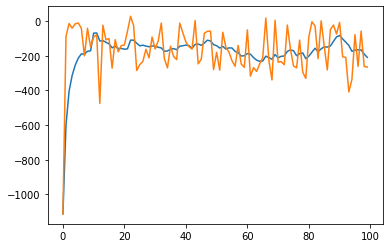

In [26]:
plt.plot(avgR)
plt.plot(trackR)